In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

## Hierarchical or mixed models

Hierload_datamodels - sometimes known as mixed models, multilevel models, or random effects models, are experiencing massive adoption in psychology. Hierarchical models are suitable for datasets with, well, a hierarchy. The classic example is predicting exam scores for individual school students in different classrooms, in different schools, in different counties, or for modelling repeated-measures data, such as many participants giving many responses to different stimuli. 

At their core, hierarchical models take care of the key independent-and-identically-distributed - **i.i.d** that has been implicitly present in every analysis or regression model covered so far. Simply, this assumption states that each observed datapoint should be independent from the others, and distributed in the same way (i.e., perhaps coming from a normal distribution, a Poisson, etc). In repeated measures data, this is obviously violated - some responses come from one participant, some from another, and so on. In the school example, students in a classroom are probably more similar than those in another, and perhaps schools in some counties are more similar overall than others. Indeed, the longer you think on this, the more likely it is you will *start seeing hierarchies everywhere*. The fundamental i.i.d asusmption is pervasive, and not often met. Psychologists have typically dodged this bullet by averaging data across stimuli or participants, and analysing the subsequent average scores. But these data do not represent the actual data collected or the data-generating process!

Hierarchical models incorporate specific effects, sometimes called random effects, that are unique to each "group" in the data. For example, in a repeated measures study, a single participant would have their own unique effect 'tagged' onto the predictions of their score, to account for the fact those scores come from the same person. 

These 'random effects' take basically two forms. The most common is known as a **random intercept**. In this type of model, each grouping variable is given its own intercept value in regression (most typically an 'offset' from a global intercept), that denotes how the predictions of the data points from that group should be shifted up or down. 

The second form is that of a **random slope**. This works in exactly the same way, but for a coefficient/predictor variable - imagine that school students are given a teaching intervention that involves some extra one-to-one tuition, measured in minutes. Students receive varying amounts of tuition minutes depending on their availability - some get more, some less. A random slope would mean that students within different classrooms could have a specific coefficient value that deviates from the global effect of tuition minutes.

In practice, both random slopes and random intercepts are combined in models. 

### Fitting hierarchical models with `statsmodels` - random intercepts and slopes
The `mixedlm` function will estimate a hiearchical model for us. Note that this function is back in the realm of normal, linear regression - no more generalized linear madness now! To highlight the flexibility of these models, we will use the `sleepstudy` dataset, which is ideally suited to highlight random effects. The data contains reaction times on a series of tasks while they are sleep deprived (three hours per night) over the course of 10 days. The first two days are baseline and adaptation. 

First, we read it in:

In [28]:
# Read sleep data
sleep = pd.read_csv('https://figshare.com/ndownloader/files/31181002')
display(sleep)

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308
...,...,...,...
175,329.6076,5,372
176,334.4818,6,372
177,343.2199,7,372
178,369.1417,8,372


We can plot the reactions time over each day, for each of the participants:

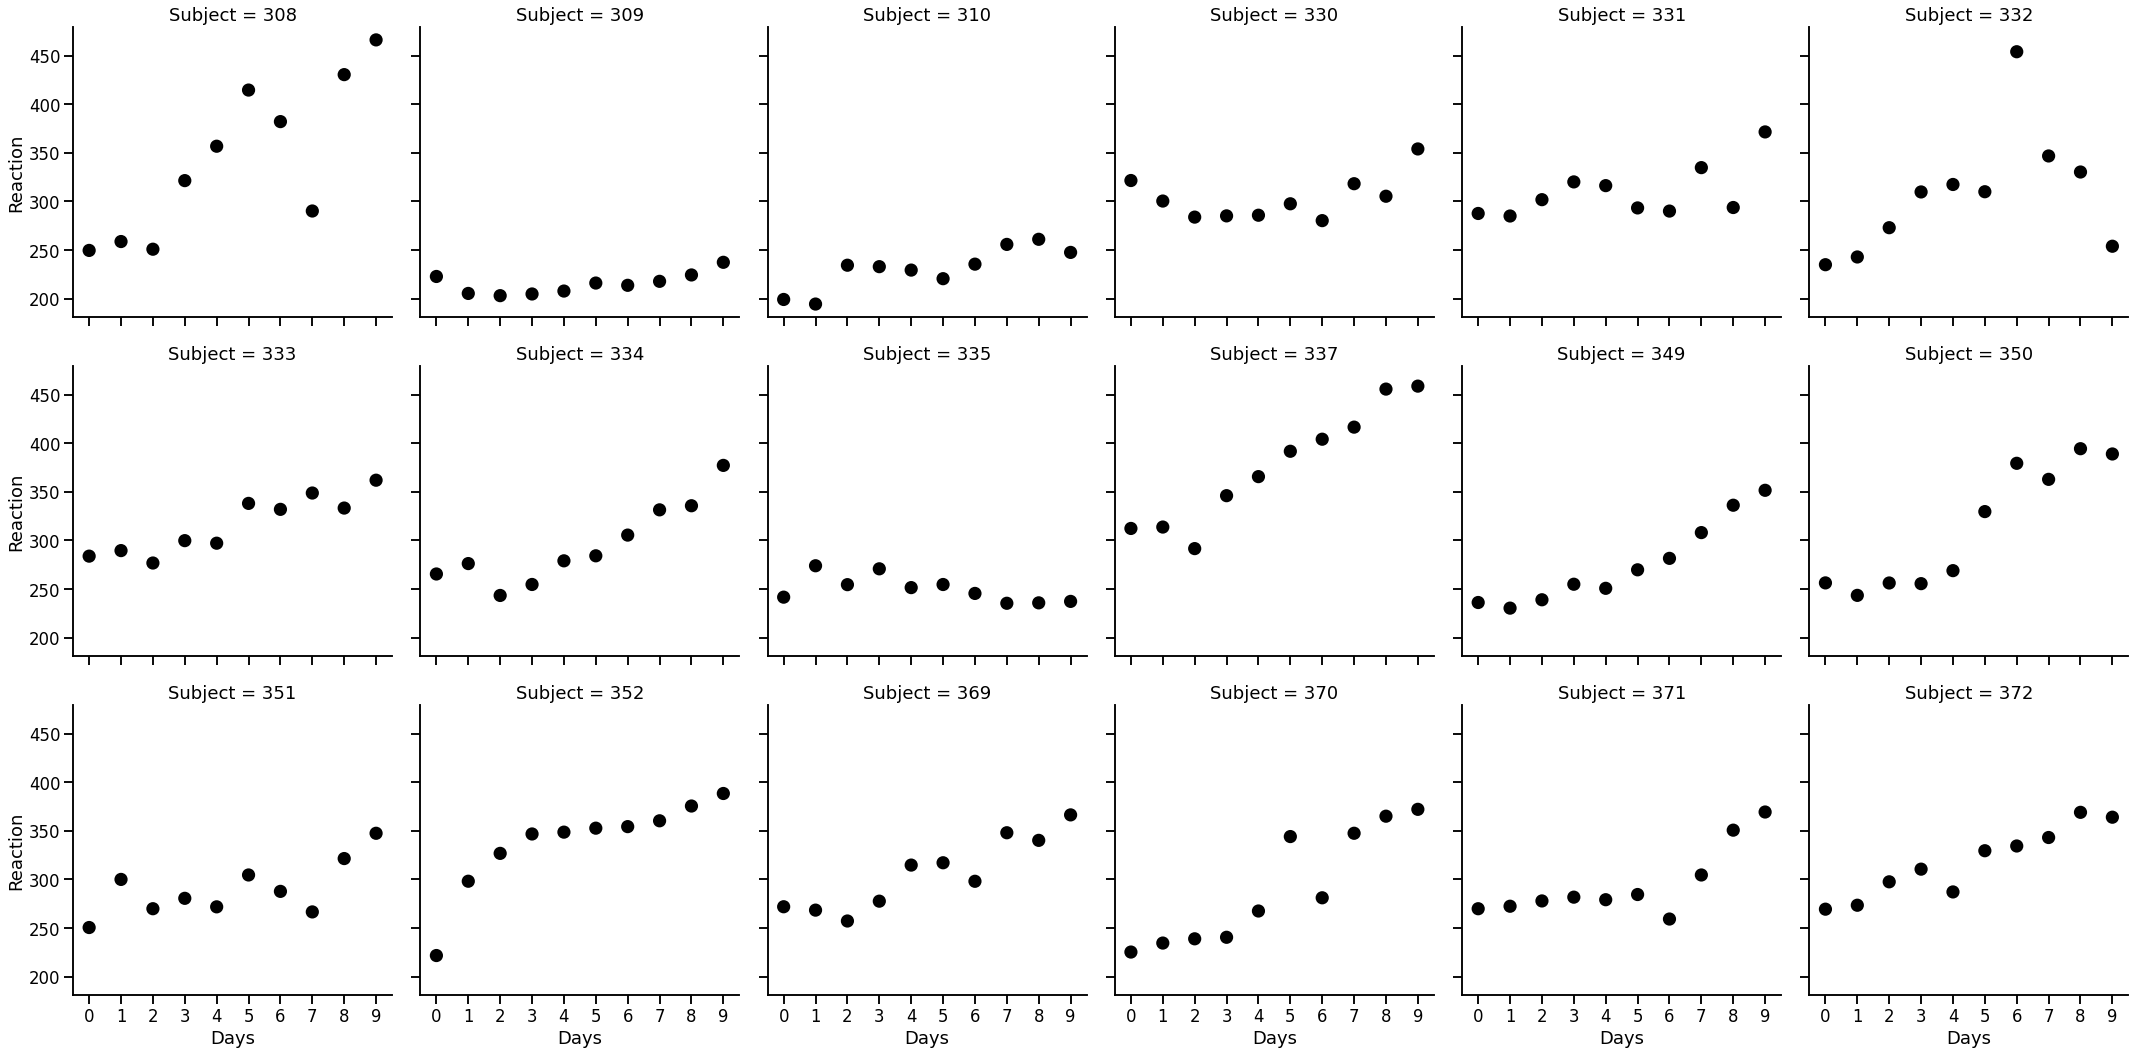

In [42]:
# Plot
with sns.plotting_context('talk'):
    
    sns.catplot(data=sleep, x='Days', y='Reaction', col='Subject', 
                col_wrap=6, kind='point', join=False, color='black', alpha=.3)

There is a lot of variation here. Each subject has a different pattern! For example subject 309 is really consistent but subject 337 trends upwards (slowing their reaction time) across the study. With this dataset, we can show off the mixed-model capabilities of `statsmodels`. 

We want to:
- Always predict the reaction time from days of sleep deprivation
1. Allow the model to vary the intercept (start-point) for each subject
2. Allow the model to vary the coefficient of day for each subject (effect of days of deprivation)
3. Allow the model to do both

#### Random intercepts only
Lets get started. Below we show how part 1. The `mixedlm` function accepts a formula as usual, but has an additional argument, `groups`, that allows us to specify the grouping data.

In [31]:
# First use of mixedlm, a random-intercepts only model
random_intercepts = smf.mixedlm('Reaction ~ Days', groups='Subject', data=sleep).fit()

# Summary
random_intercepts.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:             MixedLM  Dependent Variable:  Reaction 
No. Observations:  180      Method:              REML     
No. Groups:        18       Scale:               960.4568 
Min. group size:   10       Log-Likelihood:      -893.2325
Max. group size:   10       Converged:           Yes      
Mean group size:   10.0                                   
----------------------------------------------------------
             Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept    251.405    9.747 25.794 0.000 232.302 270.508
Days          10.467    0.804 13.015 0.000   8.891  12.044
Subject Var 1378.176   17.156                             
==========================================================

"""

Interesting! The model shows us the number of groups (18), which is equal to the number of participants. It shows the group size is 10 - the number of observations provided by each participant. The `Intercept` and `Days` data have their usual interpretation - the intercept is the average reaction time when day is zero (so the start point) and Days is the increase in reaction time as each day goes by, so an additional 10.467 ms are added per day. 

The `Subject Var` coefficient represents the variability in reaction time due to the different subjects. We can divide that by the total variability if we wish to get a kind of 'variance explained':

In [32]:
# Compute variance explained
random_intercepts.cov_re / sleep['Reaction'].var()

,Subject
Subject,0.434354


We've allowed each participant here their own intercept. Where are they? We can access that using the `.random_effects` attribute. As can be seen, this returns a dictionary with keys as the individual participant identifiers, and a value which represents the random effect - actually each participants *offset* from the global intercept. We'd like this as a DataFrame, so first we extract it:

In [34]:
# Extract offsets to df using the .from_dict method in the constructor
intercepts = pd.DataFrame.from_dict(random_intercepts.random_effects, orient='index')

To see each participants individual intercept, we simply add the **global intercept** of the model! We can grab this from the `.fe_params` attribute of the fitted model (`fe` being 'fixed effect', i.e., not random)

In [35]:
# Add the global intercept
intercepts = intercepts + random_intercepts.fe_params['Intercept']
intercepts

,Subject
308,292.188809
309,173.555562
310,188.296546
330,255.811546
331,261.621293
332,259.626342
333,267.905597
334,248.408124
335,206.122984
337,323.587781


Each participants baseline reaction time is estimated. Let's next examine the actual predictions of this model, which allows us to account for each participants baseline. First, we insert the `.fittedvalues` into the sleep data. 

Second, we have to do some *slightly* more complex graph action to show these results. We utilise the `seaborn` class `FacetGrid`, which allows us to split a dataset up by a grouping factor and map a specfic plotting function to each subgroup. First we plot the raw data, and then the estimated regression line.

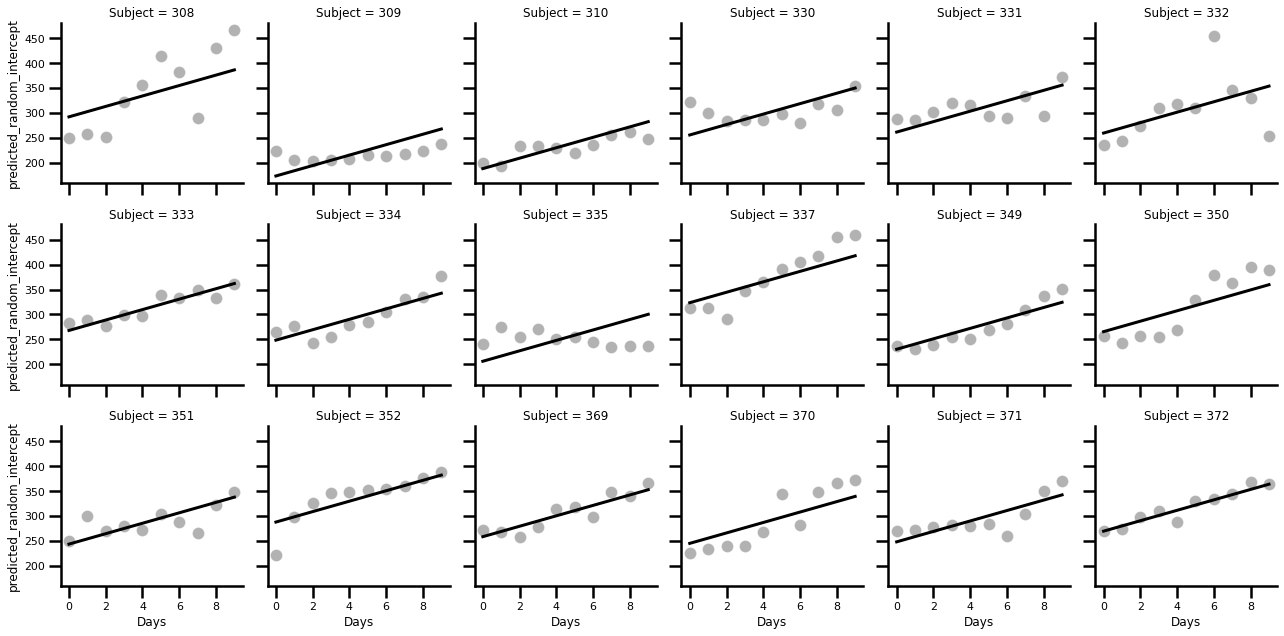

In [36]:
# Insert
sleep['predicted_random_intercept'] = random_intercepts.fittedvalues

# Now plot using FacetGrid
with sns.plotting_context('poster', font_scale=0.5):
    
    (
        sns.FacetGrid(data=sleep, col='Subject', col_wrap=6)
        .map_dataframe(sns.scatterplot, x='Days', y='Reaction', color='black', alpha=.3)
        .map_dataframe(sns.lineplot, x='Days', y='predicted_random_intercept', color='black', linewidth=3)
    )

Kind of amazing. It is evident that the random intercepts are true to their name - each participants estimated regression line starts at a different point, but the slope is absolutely identical across the participants, and sometimes with disastrous predictions (eg subject 335). 

#### Random slopes only
How about if we allow the effect of day to vary using a random slope? We can now demonstrate how to add this in (and keep the intercepts totally fixed!). We need to add an additional dictionary to the model specification under the keyword `vc`, which stands for variance components. The `'0 + Days'` description indicates to the model to remove the participant-specific intercept, and estimate only a random effect for the Days coefficient. 

We estimate the model, store the predictions, and plot the data. Its also entirely possible to extract the random slopes themselves, and add the fixed effect of day to them, if required. The process is the same.

In [37]:
# Estimate a random slope only regression
random_slopes = smf.mixedlm('Reaction ~ Days', groups='Subject',
                            vc_formula={'Days': '0 + Days'},
                            data=sleep).fit()
random_slopes.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: Reaction 
No. Observations: 180     Method:             REML     
No. Groups:       18      Scale:              842.0310 
Min. group size:  10      Log-Likelihood:     -883.2625
Max. group size:  10      Converged:          Yes      
Mean group size:  10.0                                 
-------------------------------------------------------
           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------
Intercept 251.405    4.020 62.539 0.000 243.526 259.284
Days       10.467    1.870  5.599 0.000   6.803  14.132
Days Var   52.707    0.692                             
=======================================================

"""

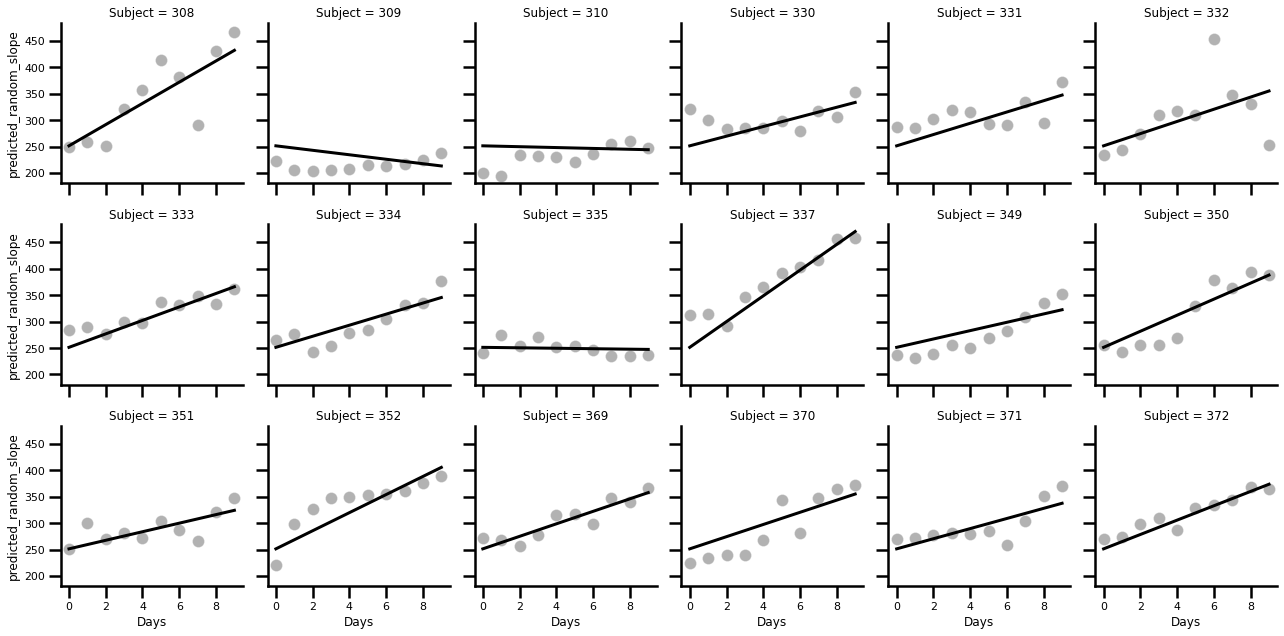

In [38]:
# Insert
sleep['predicted_random_slope'] = random_slopes.fittedvalues

# Plot once more with facet grid
with sns.plotting_context('poster', font_scale=0.5):
    
    (
        sns.FacetGrid(data=sleep, col='Subject', col_wrap=6)
        .map_dataframe(sns.scatterplot, x='Days', y='Reaction', color='black', alpha=.3)
        .map_dataframe(sns.lineplot, x='Days', y='predicted_random_slope', color='black', linewidth=3)
    )

We are now in eessentially the opposite position. Its clear that each slope varies, but notice that it *starts in the same position* on the y-axis, because the intercept is fixed across all participants! For some participants, the fit is pretty good already - e.g. Subject 372; but for others it is poor, e.g 309. 

### Putting it all together
We are now in a position where we can essentially combine the two approaches. We can fit a model that has random intercepts *and* slopes, allowing the starting position and the slope of the line to be unique for each participant. Putting this together in `statsmodels` is very easy, and relies on the use of the `re_formula` keyword.

In [39]:
# Estimate a random intercepts and slopes regression
random_all = smf.mixedlm('Reaction ~ Days', groups='Subject',
                         re_formula='Days',
                         data=sleep).fit()
random_all.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:               MixedLM    Dependent Variable:    Reaction 
No. Observations:    180        Method:                REML     
No. Groups:          18         Scale:                 654.9405 
Min. group size:     10         Log-Likelihood:        -871.8141
Max. group size:     10         Converged:             Yes      
Mean group size:     10.0                                       
----------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept          251.405    6.825 36.838 0.000 238.029 264.781
Days                10.467    1.546  6.771 0.000   7.438  13.497
Subject Var        612.096   11.881                             
Subject x Days Cov   9.605    1.821                             
Days Var            35.072    0.610                             
================================================================

"""

The output now includes a variance estimate for each of the intercepts, slopes, and their interaction (Subject, Days, and Subject x Days respectively). Accordingly, the `.random_effects` dictionary will now contain two values per participant - the slope and intercept estimate.

Finally, lets see the predictions for this, using the same logic as before.

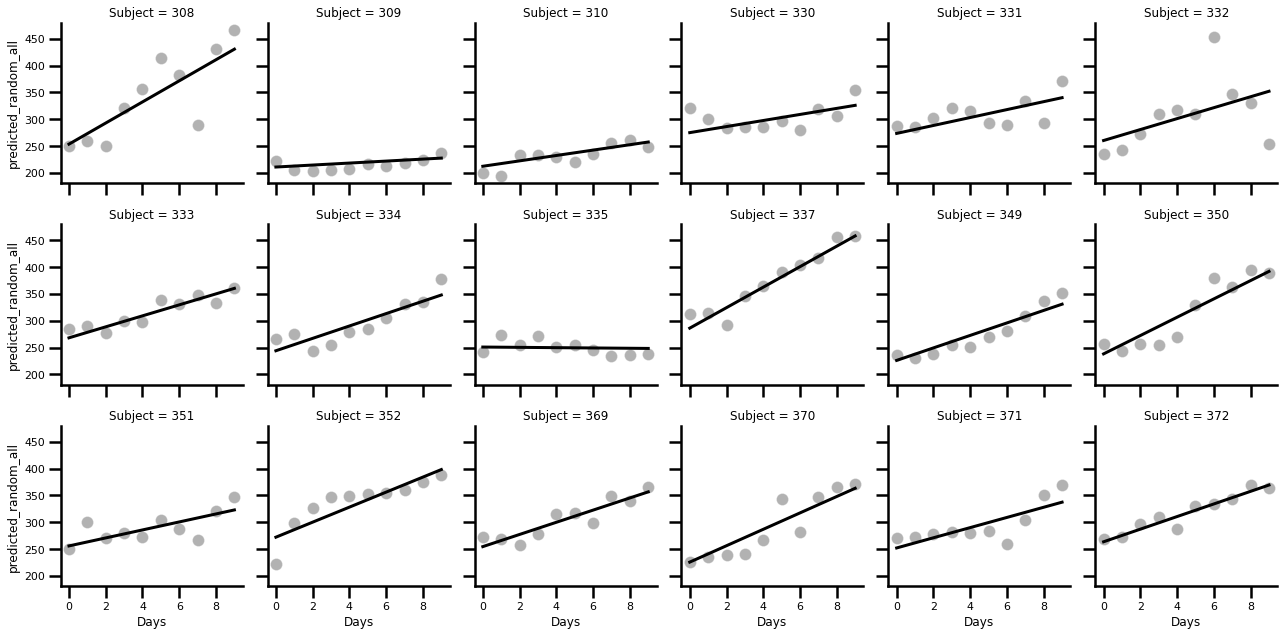

In [40]:
# Insert
sleep['predicted_random_all'] = random_all.fittedvalues

# Plot once more with facet grid
with sns.plotting_context('poster', font_scale=0.5):
    
    (
        sns.FacetGrid(data=sleep, col='Subject', col_wrap=6)
        .map_dataframe(sns.scatterplot, x='Days', y='Reaction', color='black', alpha=.3)
        .map_dataframe(sns.lineplot, x='Days', y='predicted_random_all', color='black', linewidth=3)
    )

Perfect! Those random effects worked really well, allowing for the slope and intercept to vary for each participant. 

But how should one choose whether to use random intercepts, slopes, or both? There are many schools of thought on this with no dominant view. In psychology, a popular approach is the 'keep it maximal' one of [Barr et al, 2013](https://talklab.psy.gla.ac.uk/KeepItMaximalR2.pdf), which suggests that you should include all the random intercepts and slopes that your data allows for. Others claim this makes the models overly saturated, unidentifiable, and ultimately uninterpretable [Bates et al](https://www.sfs.uni-tuebingen.de/~hbaayen/publications/BatesKlieglVasishthBaayenParsimoneousLMMs2015.pdf). Ultimately, the price we pay for more complex models like the hierarchical ones seen here is that we must make more decisions, and that we must be able to defend these decisions. 

### Further mixed models and notes
The model shown above is a hierarchical cousin of the standard OLS model. Its entirely possible to fit generalized hierarchical models for binary or count data, and `statsmodels` [can do that](https://www.statsmodels.org/dev/mixed_glm.html?highlight=bayes#module-statsmodels.genmod.bayes_mixed_glm), but computation of these complex models becomes tricky. Bayesian models can help here, but that is another story!

Finally, there are often times with experimental data when it would be good to include multiple random intercepts and slopes - for example, participants rating stimuli for attractiveness, where both participants and stimuli have different baselines and intercepts. These are less straightforward to implement and rely on a good working knowledge of the *variance components* side of `mixedlm`. This is an unfortunate aspect of `mixedlm` in contrast to other languages and packages (e.g. the `lmer` library in $R$), but it does at least build significant knowledge when trying to work with complex data. 

